# K means clustering
## Introduction 

With the k-nearest neighbors algorithm, we are able to succesfuly classify an unknown datapoint given some labelled data. A more complex scenario is achieveing a classification strategy in the absence of labelled data, (i.e our training set is not labelled.) In essence, how do we draw decision boundaries in our data when we do not have labels? The k-means clustering algorithm can achieve this through an iterative optimization process. K means attempts to sort data into K distinct labels or 'clusters'. It is a type of *unsupervised learning* algorithm. We create a a fake dataset below for demonstration purposes. 

Text(0, 0.5, 'Fruit Height (cms)')

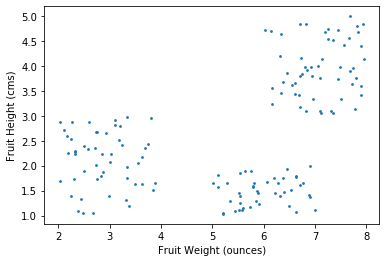

In [33]:
from matplotlib import pyplot as plt
from matplotlib import colors
import random
import pandas as pd
import numpy as np
import statistics

# Create a fake dataset of fruit weight, height, and label
fruit_weight = []
fruit_height = []

for i in range(150):
    probability = random.uniform(0,1)
    if probability < 0.33: 
        fruit_weight.append(random.uniform(2, 4))
        fruit_height.append(random.uniform(1, 3))

    elif probability > 0.33 and probability < 0.66:
        fruit_weight.append(random.uniform(6, 8))
        fruit_height.append(random.uniform(3, 5))

        
    else: 
        fruit_weight.append(random.uniform(5, 7))
        fruit_height.append(random.uniform(1, 2))
    
fruit_weight = np.asarray(fruit_weight)
fruit_height = np.asarray(fruit_height)

# Combine data into single matrix where each row represents a datapoint
# and each column represents a feature
data = np.concatenate((fruit_weight.reshape(len(fruit_weight), 1), fruit_height.reshape(len(fruit_height), 1)),axis=1)

# Plot the data        
fig, ax = plt.subplots()        
ax.scatter(data[:,0], data[:,1], s=3)
ax.set_xlabel("Fruit Weight (ounces)")
ax.set_ylabel("Fruit Height (cms)")

## Producing labels for our data

We reuse our made up fruit weights and heights dataset for this example. A quick glance at the data, and it's easy for people to decipher 3 distinct clusters. Our ability to perceive this natural grouping is a reflection of how well the human visual cortex has evolved to find patterns and orders very quickly. The KMC algorithm does not have the advantage of this visual intuition like we do. However, KMC is clever in its ability to infer very similar classification outputs by using a few simple steps: 

1. For K = 3 (user decided), initialize 3 random points that will represet the 'centers' of our clusters
2. Label each data point using a simple smallest euclidian distance criteria (i.e the datapoint is labelled to whichever center is closest to it.) 
3. Re-compute 3 new centers by computing the mean of the labelled data points from step 2. 
4. Repeat starting from step 2 until there is no significant change in cluster center movement (convergence)

Our euclidian distance is calculated the exact same way as was done in K nearest neighbors. For any given datapoint $b$, we compute the three distances as: 
### cluster_1_distance = $\sqrt{  \sum_{n=0}^{i} (c^1_{i} - b_{i})^2 } $
### cluster_2_distance = $\sqrt{  \sum_{n=0}^{i} (c^2_{i} - b_{i})^2 } $
### cluster_3_distance = $\sqrt{  \sum_{n=0}^{i} (c^3_{i} - b_{i})^2 } $

Here, $c^1$, $c^2$, $c^3$, represent cluster point centers 1,2 and 3 respectively. $i$ reflects the number of features we are iterating over in our summation. Upon computing these distances, point $b$ is assigned a label of 1,2 or 3 based on whichever cluster distance turns out to be the smallest. 

A full overview of this process is demonstrated in the image below:

![kMeansUrl](https://miro.medium.com/max/960/0*f9HcysjkU6XyM1hb.gif "kmeans")

## Checking for convergence
Our convergence criteria is simple. We assume convergence when the shift in centroid values is smaller than some predefined threshold (ex: change is smaller than 0.01.) This implies that the centers have found an equillibrium amongst the clustering. 

The next section details a quick implementation of KMC from scratch for a 2D feature space. 

## Code:

CONVERGED
3


Text(0, 0.5, 'Fruit Height (cms)')

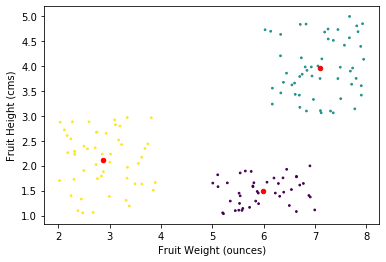

In [88]:
# Compute the euclidian distance given two feature vectors
def compute_euclidian(d1, d2):
    euclidian = np.sqrt(np.sum((d1-d2)**2))
    return euclidian

def find_closest_centroid(centers,datapoint): 
    
    # Initialize empty aray 
    euclidians = np.zeros((1, len(centers))).flatten()
    
    # Compute the euclidian distance for each center to the datapoint
    for index, center in enumerate(centers):
        euclidians[index] = compute_euclidian(center, datapoint)
        
    # Return the index of whichever center was closest to the datapoint
    return np.argmin(euclidians)

# Create clusters by grouping indices based on which centroid they are closest to
def create_clusters(centers): 
    
    # Initialize an empty list of lists where each list will hold the indices of the 
    # points belonging to one cluster 
    clusters = [[] for _ in range(len(centers))]
    
    # Assign each datapoint to the closest centroid label, and group these indices
    for index, datapoint in enumerate(data): 
        closest_cluster = find_closest_centroid(centers, datapoint)
        clusters[closest_cluster].append(index)
        
    # [[indices belonging to cluster 1], [indices belonging to cluster 2]...]
    return clusters 

# Re-comute the centers of the clusters
def compute_centroids(data, old_centers, clusters):
    
    # Empty list that will hold new centers 
    new_centroids = []
    # Calculate the new centers
    for index, cluster in enumerate(clusters):
        # If no datapoint belonged to the centroid label, use the last centroid value (no update)
        if len(data[cluster]) == 0:
            new_centroids.append(old_centers[index])
        # Otherwise append the new centroid value
        else: 
            new_centroids.append(np.mean(data[cluster], axis=0))
        
    return new_centroids
    
# Check convergence criteria
def is_converged(old_centroids, new_centroids):
    for i in range(len(old_centroids)):
        # If any one euclidian distance difference between updates is greater than 0.01
        # we have not yet reached convergence
        if compute_euclidian(old_centroids[i], new_centroids[i]) > 0.01:
            return False
        
    # Only return true when the above condition is met
    print("CONVERGED")
    return True 
        
# Grab the cluster labels for plotting
def get_cluster_labels(clusters, data):
    
    labels = np.zeros((1, len(data))).flatten()
    for cluster_label, cluster in enumerate(clusters):
        for sample_index in (cluster):
            labels[sample_index] = int(cluster_label)
            
    return labels

# Compute k nearest neighbors for 2 features (2D case) 
def k_nearest_neighbors(k, data, max_iter=1000): 
    
    '''
        k: 
            Number of clusters
        feature_1: 
            array of the first feature (weights)
        feature_2: 
            array of the second feature (heights)
    '''
    
    # Initialize random centers by first grabbing 3 random indices 
    # Replace flag ensures no duplicates are chosen
    random_centroid_indices = np.random.choice(len(data[:,0]), k, replace=False)
    
    # Grab 3 random points using those indices 
    new_centers = [data[indx] for indx in random_centroid_indices]
    
    for i in range(max_iter):
        # Create clusters
        prev_centers = new_centers
        clusters = create_clusters(prev_centers)
        # Re-compute centers
        new_centers = compute_centroids(data, prev_centers, clusters)
        if is_converged(prev_centers, new_centers):
            labels = get_cluster_labels(clusters, data)
            print(i)
            break
        
    return new_centers, labels 

# Compute k means clustering for our data set using k = 3
centers, labels = k_nearest_neighbors(3, data)

# Plot the data        
fig, ax = plt.subplots()        
ax.scatter(data[:,0], data[:,1], c=labels,s=3)
for center in centers:
    ax.scatter(center[0], center[1], s=20, color='red')
ax.set_xlabel("Fruit Weight (ounces)")
ax.set_ylabel("Fruit Height (cms)")
    

## Evaluating cluster quality
The data we started with is quite sparse, so the KMC algorithm only needs a few iterations to converge very quickly. In the real world, our data sets are often a lot larger, and may include many more features per data point (clusters in 'n' dimensional' space.) Though our example makes it easy to narrow down our ideal K value via visual inspection (k=3 in this case), often times this is not readily apparent. We need a more robust analytical method to evaluate the quality of our clustering for most real world cases. What is our metric for 'good clustering', and how can we arrive at a K value that maximizes this metric? 

## Using Inertia and elbow plots 
One way of measuring clustering quality is by quantifying how 'tightly' packed the clustering is. If the distance between the predicted centers and the labelled points is small, it reflects strong grouping (as opposed to centroids that group very spread out points.) Inertia encapsulates this criteria by computing the **sum of the squared euclidian distances** between the centroids, and their respective labelled data points. For different values of 'k', we can compute the **total inertia over k centroids**. This inertial value is what we aim to reduce. 

### Inertia  for centroid 'm' = $ \sum_{n=0}^{n}~(euclidian(~c^m,~d[n]~))$
Here, the sum n refers to all the points that belong to centroid 'm'
### Total inertia = $ \sum_{m=0}^{k}~(\sum_{n=0}^{n}~(euclidian(~c^m,~d[n]~))  $ for 'k' centroids

We define a function to compute inertia below


In [91]:
def compute_inertia(k, data): 
    
    centers, labels = k_nearest_neighbors(k, data)
    summation = 0
    print(labels)
    for label in labels: 
        summation += (centers[label] - data[label])**2
        
    return summation

Now we compute the inertial value for different values of k

In [92]:
inertia = np.zeros((1, 11)).flatten()
for k in range(1,10): 
    inertia[k] = compute_inertia(k, data)
    
fig, ax = plt.subplots()        
ax.scatter(np.linspace(1,10,10), inertia, s=3)

CONVERGED
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


TypeError: list indices must be integers or slices, not numpy.float64